In [1]:
import pandas as pd
import numpy as np
from collections import Counter 
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv("../input/flickr8k/captions.txt", sep=',')
print(len(df))
df.head(5)

40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [3]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [4]:
df['clean_captions'] = df['caption'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])
df['clean_captions']  = df['clean_captions'].apply(lambda x : remove_single_char_word(x))

In [5]:
df['seq_length'] = df['clean_captions'].apply(lambda x : len(x))
max_seq_len = df['seq_length'].max()
print(max_seq_len)

33


In [6]:
df.drop(['seq_length'], axis = 1, inplace = True)
df['clean_captions'] = df['clean_captions'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

In [7]:
words_list = df['clean_captions'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
words_dict = Counter(words_list)
words_dict =  sorted(words_dict, key=words_dict.get, reverse=True)

In [8]:
vocab_size = len(words_dict)
print(vocab_size)

8360


In [9]:
index_to_word = {index: word for index, word in enumerate(words_dict)}
word_to_index = {word: index for index, word in enumerate(words_dict)}
print(len(index_to_word), len(word_to_index))

8360 8360


In [10]:
df['text_seq']  = df['clean_captions'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [11]:
df = df.sort_values(by = 'image')
train = df.iloc[:int(0.9*len(df))]
valid = df.iloc[int(0.9*len(df)):]

In [12]:
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

7282 810


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [14]:
class extractImageFeatureDataSet():
    def __init__(self, data, size):
        self.data = data 
        self.scaler = transforms.Resize([size,size])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):  
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image']
        img_loc = '../input/flickr8k/Images/'+str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [15]:
train_ImageDataset_ResNet = extractImageFeatureDataSet(unq_train_imgs , 224)
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size = 1, shuffle=False)

valid_ImageDataset_ResNet = extractImageFeatureDataSet(unq_valid_imgs , 224)
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [16]:
for ima,image in tqdm(train_ImageDataloader_ResNet):
    print(f'Image size for Resnet Features: {image.shape}')
    break

  0%|          | 0/7282 [00:00<?, ?it/s]

Image size for Resnet Features: torch.Size([1, 3, 224, 224])


In [17]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 224MB/s]


['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [18]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [19]:
def get_resnet_vector(t_img):
    
    t_img = Variable(t_img)
#     print(t_img)
    my_embedding = torch.zeros(1, 512, 7, 7)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    
    h = resNet18Layer4.register_forward_hook(copy_data)
    resnet18(t_img)
    
    h.remove()
    return my_embedding

In [20]:
def writeResnetPickle(loader,name):
    picklDict = {}
    for image_name,img in tqdm(loader):
        img = img.to(device)
        embdg = get_resnet_vector(img)
        
        picklDict[image_name[0]] =  embdg
    
    a_file = open(f'./{name}.pkl', "wb")
    pickle.dump(picklDict, a_file)
    a_file.close()
    
    return "Done"

In [21]:
writeResnetPickle(train_ImageDataloader_ResNet,'resnetTrainEncoder')
writeResnetPickle(valid_ImageDataloader_ResNet,'resnetValidEncoder')

  0%|          | 0/7282 [00:00<?, ?it/s]

  0%|          | 0/810 [00:00<?, ?it/s]

'Done'

In [22]:
class FlickerDataSet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [23]:
def getEncodedLoader(data,pickleFile,train):
    dataset = FlickerDataSet(data,pickleFile)
    if train:
        loader = DataLoader(dataset, batch_size = 32, shuffle = True)
    else:
        loader = DataLoader(dataset, batch_size = 32, shuffle = False)
    
    return loader

In [24]:
train_resnet_loader = getEncodedLoader(train,'resnetTrainEncoder.pkl',True)
valid_resnet_loader = getEncodedLoader(valid, 'resnetValidEncoder.pkl',False)

In [25]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

In [26]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)
        
#         print(decoder_inp)
        
#         print(self.embedding_size)
        
        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        
#         print(f'First one: {decoder_inp_embed}')
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        
#         print(f'mask: {decoder_input_mask}')
#         print(f'second one: {decoder_inp_embed}')

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask


In [27]:
EPOCH = 30

In [28]:
float('Inf')

inf

In [29]:
ictModel = ImageCaptionModel(n_head=16, n_decoder_layer=5, vocab_size=vocab_size, embedding_size=512).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = float('Inf')

In [30]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_resnet_loader:

        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

 
    total_epoch_train_loss = total_epoch_train_loss/total_train_words
  

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_resnet_loader:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
    
    train_losses = []
    valid_losses = []
  
    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )
    
    train_losses.append(total_epoch_train_loss.item())
    valid_losses.append(total_epoch_valid_loss.item())
    
    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel.pt')
        min_val_loss = total_epoch_valid_loss
  

    scheduler.step(total_epoch_valid_loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch ->  0  Training Loss ->  5.341730117797852 Eval Loss ->  4.388141632080078
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  4.214171886444092 Eval Loss ->  3.984910249710083
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  3.897783041000366 Eval Loss ->  3.788482189178467
Writing Model at epoch  2
Epoch ->  3  Training Loss ->  3.700347900390625 Eval Loss ->  3.66318941116333
Writing Model at epoch  3
Epoch ->  4  Training Loss ->  3.5578911304473877 Eval Loss ->  3.5741536617279053
Writing Model at epoch  4
Epoch ->  5  Training Loss ->  3.439399480819702 Eval Loss ->  3.5051920413970947
Writing Model at epoch  5
Epoch ->  6  Training Loss ->  3.341796636581421 Eval Loss ->  3.4517743587493896
Writing Model at epoch  6
Epoch ->  7  Training Loss ->  3.255577802658081 Eval Loss ->  3.409825086593628
Writing Model at epoch  7
Epoch ->  8  Training Loss ->  3.178565263748169 Eval Loss ->  3.369030237197876
Writing Model at epoch  8
Epoch ->  9  Training Loss ->  3.1

In [31]:
torch.save(ictModel,'FinalModel.pt')

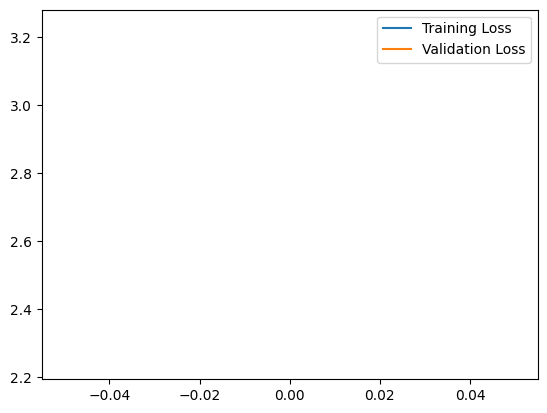

<Figure size 640x480 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label = 'Training Loss')
plt.plot(valid_losses, label = 'Validation Loss')

plt.legend()
plt.show()

plt.savefig('Loss.png')

In [33]:
model = torch.load('BestModel.pt')
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 33
print(start_token, end_token, pad_token)

1 2 0


In [34]:
valid_img_embed = pd.read_pickle('resnetValidEncoder.pkl')

In [35]:
def generate_caption(K, img_nm): 
    img_loc = '../input/flickr8k/Images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

Actual Caption : 
['Young child in pink top and purple pants clutching a turquoise guard rail .', 'A very young girl is walking on a playground .', 'The little girl is playing at the playground .', 'A little girl in pink and purple stands on a playground .', 'A female toddler wearing a pink shirt is playing on a playground .']


Predicted caption : 
little girl in pink shirt and jeans is standing on playground slide .


/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


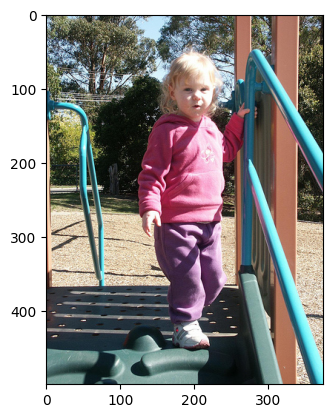

In [36]:
generate_caption(1, unq_valid_imgs.iloc[50]['image'])

Actual Caption : 
['Young child in pink top and purple pants clutching a turquoise guard rail .', 'A very young girl is walking on a playground .', 'The little girl is playing at the playground .', 'A little girl in pink and purple stands on a playground .', 'A female toddler wearing a pink shirt is playing on a playground .']


Predicted caption : 
little girl is standing in front of slide .


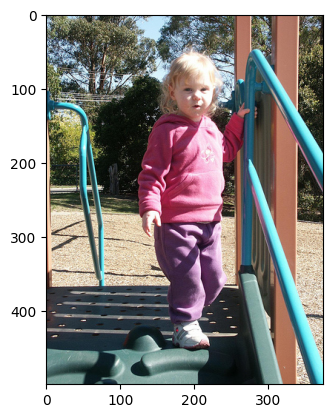

In [37]:
generate_caption(2, unq_valid_imgs.iloc[50]['image'])